In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer
from tqdm import tqdm

from model.bi_lstm import BiLSTMAttentionABSA
from model.pho_bert import PhoBERT_ABSA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda


In [ ]:
class ABSADataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_len=128):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.aspects = ['Price', 'Shipping', 'Outlook', 'Quality', 'Size', 'Shop_Service', 'General', 'Others']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = str(self.data.iloc[index]['Cleaned_Review'])

        labels = []
        for aspect in self.aspects:
            label = self.data.iloc[index][aspect]
            labels.append(3 if label == -1 else label)

        encoding = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

train_dataset = ABSADataset('datasets_cleaned/train_data.csv', tokenizer)
val_dataset = ABSADataset('datasets_cleaned/val_data.csv', tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
aspects = ['Price', 'Shipping', 'Outlook', 'Quality', 'Size', 'Shop_Service', 'General', 'Others']

aspect_weights = []

print("Đang tính toán ma trận trọng số cho 8 khía cạnh...")
for aspect in aspects:
    y_true = train_dataset.data[aspect].values

    y_mapped = [3 if y == -1 else y for y in y_true]

    classes = np.unique(y_mapped)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_mapped)

    weight_dict = dict(zip(classes, weights))

    final_weights = [weight_dict.get(i, 0.0) for i in range(4)]

    weight_tensor = torch.tensor(final_weights, dtype=torch.float).to(device)
    aspect_weights.append(weight_tensor)

print("Đã tính toán xong 8 bộ trọng số!")

Đang tính toán ma trận trọng số cho 8 khía cạnh...
Đã tính toán xong 8 bộ trọng số!


In [ ]:
def train_and_evaluate(model, train_loader, val_loader, aspect_weights, epochs=5, lr=2e-5, is_phobert=True):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterions = [nn.CrossEntropyLoss(weight=w) for w in aspect_weights]

    history_loss = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        print(f"--- Epoch {epoch+1}/{epochs} ---")
        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            if is_phobert:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                outputs = model(input_ids)

            loss = 0
            for i in range(8):
                loss += criterions[i](outputs[i], labels[:, i])

            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_epoch_loss = total_train_loss / len(train_loader)
        history_loss.append(avg_epoch_loss)
        print(f"Average Training Loss: {avg_epoch_loss:.4f}")

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                if is_phobert:
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                else:
                    outputs = model(input_ids)

                batch_preds = []
                for i in range(8):
                    preds = torch.argmax(outputs[i], dim=1)
                    batch_preds.append(preds.cpu().numpy())

                val_preds.append(np.array(batch_preds).T)
                val_labels.append(labels.cpu().numpy())

        val_preds = np.vstack(val_preds)
        val_labels = np.vstack(val_labels)

        aspect_names = ['Price', 'Shipping', 'Outlook', 'Quality', 'Size', 'Shop_Service', 'General', 'Others']

        macro_f1_list = []
        print("\n--- Chi tiết F1-Score trên tập Validation ---")

        for i in range(8):
            col_preds = val_preds[:, i]
            col_labels = val_labels[:, i]

            aspect_f1 = f1_score(col_labels, col_preds, average='macro', zero_division=0)
            macro_f1_list.append(aspect_f1)

            print(f"- Khía cạnh [{aspect_names[i]}]: {aspect_f1:.4f}")

        overall_macro_f1 = np.mean(macro_f1_list)
        print(f"\n=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: {overall_macro_f1:.4f}\n")
        print("-" * 50)

    return model, history_loss

In [ ]:
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
print("BẮT ĐẦU HUẤN LUYỆN: BiLSTM-Attention")
bilstm_model = BiLSTMAttentionABSA(vocab_size=64001, embedding_dim=256, hidden_dim=256)
trained_bilstm, bilstm_losses = train_and_evaluate(bilstm_model, train_loader, val_loader, aspect_weights, epochs=50, lr=1e-3, is_phobert=False)
bilstm_path = os.path.join(save_dir, 'bilstm_absa_weights.pth')
torch.save(trained_bilstm.state_dict(), bilstm_path)

BẮT ĐẦU HUẤN LUYỆN: BiLSTM-Attention
--- Epoch 1/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 19.49it/s]


Average Training Loss: 7.5918

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5114
- Khía cạnh [Shipping]: 0.6943
- Khía cạnh [Outlook]: 0.5394
- Khía cạnh [Quality]: 0.4603
- Khía cạnh [Size]: 0.6560
- Khía cạnh [Shop_Service]: 0.5367
- Khía cạnh [General]: 0.4290
- Khía cạnh [Others]: 0.8102

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.5797

--------------------------------------------------
--- Epoch 2/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.21it/s]


Average Training Loss: 4.9637

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5357
- Khía cạnh [Shipping]: 0.7366
- Khía cạnh [Outlook]: 0.5784
- Khía cạnh [Quality]: 0.5713
- Khía cạnh [Size]: 0.6492
- Khía cạnh [Shop_Service]: 0.5397
- Khía cạnh [General]: 0.4511
- Khía cạnh [Others]: 0.8283

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6113

--------------------------------------------------
--- Epoch 3/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.58it/s]


Average Training Loss: 3.7201

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5342
- Khía cạnh [Shipping]: 0.7500
- Khía cạnh [Outlook]: 0.5959
- Khía cạnh [Quality]: 0.5791
- Khía cạnh [Size]: 0.6514
- Khía cạnh [Shop_Service]: 0.5618
- Khía cạnh [General]: 0.4776
- Khía cạnh [Others]: 0.8433

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6242

--------------------------------------------------
--- Epoch 4/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.47it/s]


Average Training Loss: 2.7172

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5309
- Khía cạnh [Shipping]: 0.7611
- Khía cạnh [Outlook]: 0.6450
- Khía cạnh [Quality]: 0.6018
- Khía cạnh [Size]: 0.6553
- Khía cạnh [Shop_Service]: 0.5885
- Khía cạnh [General]: 0.4665
- Khía cạnh [Others]: 0.8518

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6376

--------------------------------------------------
--- Epoch 5/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.74it/s]


Average Training Loss: 1.9179

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5409
- Khía cạnh [Shipping]: 0.7382
- Khía cạnh [Outlook]: 0.6510
- Khía cạnh [Quality]: 0.6108
- Khía cạnh [Size]: 0.6714
- Khía cạnh [Shop_Service]: 0.5760
- Khía cạnh [General]: 0.4827
- Khía cạnh [Others]: 0.8585

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6412

--------------------------------------------------
--- Epoch 6/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.66it/s]


Average Training Loss: 1.2998

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5424
- Khía cạnh [Shipping]: 0.7311
- Khía cạnh [Outlook]: 0.6756
- Khía cạnh [Quality]: 0.6062
- Khía cạnh [Size]: 0.6805
- Khía cạnh [Shop_Service]: 0.5967
- Khía cạnh [General]: 0.5053
- Khía cạnh [Others]: 0.8808

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6523

--------------------------------------------------
--- Epoch 7/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.74it/s]


Average Training Loss: 0.9265

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5384
- Khía cạnh [Shipping]: 0.7602
- Khía cạnh [Outlook]: 0.6570
- Khía cạnh [Quality]: 0.6374
- Khía cạnh [Size]: 0.6648
- Khía cạnh [Shop_Service]: 0.6237
- Khía cạnh [General]: 0.4646
- Khía cạnh [Others]: 0.8771

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6529

--------------------------------------------------
--- Epoch 8/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.62it/s]


Average Training Loss: 0.6965

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5522
- Khía cạnh [Shipping]: 0.7445
- Khía cạnh [Outlook]: 0.6721
- Khía cạnh [Quality]: 0.6003
- Khía cạnh [Size]: 0.6711
- Khía cạnh [Shop_Service]: 0.6008
- Khía cạnh [General]: 0.4679
- Khía cạnh [Others]: 0.8797

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6486

--------------------------------------------------
--- Epoch 9/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.80it/s]


Average Training Loss: 0.5060

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5257
- Khía cạnh [Shipping]: 0.7590
- Khía cạnh [Outlook]: 0.6823
- Khía cạnh [Quality]: 0.6144
- Khía cạnh [Size]: 0.6748
- Khía cạnh [Shop_Service]: 0.6199
- Khía cạnh [General]: 0.4549
- Khía cạnh [Others]: 0.8784

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6512

--------------------------------------------------
--- Epoch 10/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.69it/s]


Average Training Loss: 0.3620

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5283
- Khía cạnh [Shipping]: 0.7431
- Khía cạnh [Outlook]: 0.6210
- Khía cạnh [Quality]: 0.6401
- Khía cạnh [Size]: 0.6753
- Khía cạnh [Shop_Service]: 0.6440
- Khía cạnh [General]: 0.4657
- Khía cạnh [Others]: 0.8734

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6489

--------------------------------------------------
--- Epoch 11/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.77it/s]


Average Training Loss: 0.2818

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5496
- Khía cạnh [Shipping]: 0.7228
- Khía cạnh [Outlook]: 0.6489
- Khía cạnh [Quality]: 0.5971
- Khía cạnh [Size]: 0.6612
- Khía cạnh [Shop_Service]: 0.6020
- Khía cạnh [General]: 0.4783
- Khía cạnh [Others]: 0.8612

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6401

--------------------------------------------------
--- Epoch 12/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.75it/s]


Average Training Loss: 0.1892

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5406
- Khía cạnh [Shipping]: 0.7395
- Khía cạnh [Outlook]: 0.6311
- Khía cạnh [Quality]: 0.6076
- Khía cạnh [Size]: 0.6488
- Khía cạnh [Shop_Service]: 0.6539
- Khía cạnh [General]: 0.4721
- Khía cạnh [Others]: 0.8612

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6443

--------------------------------------------------
--- Epoch 13/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.64it/s]


Average Training Loss: 0.1282

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5278
- Khía cạnh [Shipping]: 0.7172
- Khía cạnh [Outlook]: 0.6447
- Khía cạnh [Quality]: 0.6181
- Khía cạnh [Size]: 0.6415
- Khía cạnh [Shop_Service]: 0.6360
- Khía cạnh [General]: 0.4840
- Khía cạnh [Others]: 0.8652

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6418

--------------------------------------------------
--- Epoch 14/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.71it/s]


Average Training Loss: 0.1377

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5516
- Khía cạnh [Shipping]: 0.7348
- Khía cạnh [Outlook]: 0.6467
- Khía cạnh [Quality]: 0.6020
- Khía cạnh [Size]: 0.6502
- Khía cạnh [Shop_Service]: 0.6488
- Khía cạnh [General]: 0.4606
- Khía cạnh [Others]: 0.8744

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6461

--------------------------------------------------
--- Epoch 15/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.71it/s]


Average Training Loss: 0.0979

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5505
- Khía cạnh [Shipping]: 0.7486
- Khía cạnh [Outlook]: 0.6796
- Khía cạnh [Quality]: 0.5879
- Khía cạnh [Size]: 0.6490
- Khía cạnh [Shop_Service]: 0.6354
- Khía cạnh [General]: 0.4677
- Khía cạnh [Others]: 0.8809

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6500

--------------------------------------------------
--- Epoch 16/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.80it/s]


Average Training Loss: 0.0859

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5423
- Khía cạnh [Shipping]: 0.7249
- Khía cạnh [Outlook]: 0.6427
- Khía cạnh [Quality]: 0.5954
- Khía cạnh [Size]: 0.6657
- Khía cạnh [Shop_Service]: 0.6213
- Khía cạnh [General]: 0.4702
- Khía cạnh [Others]: 0.8757

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6423

--------------------------------------------------
--- Epoch 17/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.77it/s]


Average Training Loss: 0.3115

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5212
- Khía cạnh [Shipping]: 0.7488
- Khía cạnh [Outlook]: 0.6913
- Khía cạnh [Quality]: 0.5797
- Khía cạnh [Size]: 0.6029
- Khía cạnh [Shop_Service]: 0.6284
- Khía cạnh [General]: 0.4447
- Khía cạnh [Others]: 0.8185

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6294

--------------------------------------------------
--- Epoch 18/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 19.17it/s]


Average Training Loss: 0.6401

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5338
- Khía cạnh [Shipping]: 0.7484
- Khía cạnh [Outlook]: 0.6608
- Khía cạnh [Quality]: 0.5821
- Khía cạnh [Size]: 0.6289
- Khía cạnh [Shop_Service]: 0.6103
- Khía cạnh [General]: 0.4826
- Khía cạnh [Others]: 0.8634

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6388

--------------------------------------------------
--- Epoch 19/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.32it/s]


Average Training Loss: 0.3102

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5457
- Khía cạnh [Shipping]: 0.7655
- Khía cạnh [Outlook]: 0.6343
- Khía cạnh [Quality]: 0.6001
- Khía cạnh [Size]: 0.6177
- Khía cạnh [Shop_Service]: 0.6369
- Khía cạnh [General]: 0.4539
- Khía cạnh [Others]: 0.8771

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6414

--------------------------------------------------
--- Epoch 20/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.78it/s]


Average Training Loss: 0.1092

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5381
- Khía cạnh [Shipping]: 0.7516
- Khía cạnh [Outlook]: 0.6285
- Khía cạnh [Quality]: 0.5996
- Khía cạnh [Size]: 0.6372
- Khía cạnh [Shop_Service]: 0.6077
- Khía cạnh [General]: 0.4746
- Khía cạnh [Others]: 0.8667

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6380

--------------------------------------------------
--- Epoch 21/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.30it/s]


Average Training Loss: 0.0558

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5561
- Khía cạnh [Shipping]: 0.7487
- Khía cạnh [Outlook]: 0.6639
- Khía cạnh [Quality]: 0.6017
- Khía cạnh [Size]: 0.6222
- Khía cạnh [Shop_Service]: 0.6131
- Khía cạnh [General]: 0.4759
- Khía cạnh [Others]: 0.8612

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6429

--------------------------------------------------
--- Epoch 22/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.45it/s]


Average Training Loss: 0.0333

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5400
- Khía cạnh [Shipping]: 0.7508
- Khía cạnh [Outlook]: 0.6220
- Khía cạnh [Quality]: 0.6037
- Khía cạnh [Size]: 0.6289
- Khía cạnh [Shop_Service]: 0.6194
- Khía cạnh [General]: 0.4758
- Khía cạnh [Others]: 0.8546

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6369

--------------------------------------------------
--- Epoch 23/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.43it/s]


Average Training Loss: 0.0249

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5364
- Khía cạnh [Shipping]: 0.7534
- Khía cạnh [Outlook]: 0.6275
- Khía cạnh [Quality]: 0.6094
- Khía cạnh [Size]: 0.6242
- Khía cạnh [Shop_Service]: 0.6222
- Khía cạnh [General]: 0.4758
- Khía cạnh [Others]: 0.8612

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6388

--------------------------------------------------
--- Epoch 24/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.71it/s]


Average Training Loss: 0.0221

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5366
- Khía cạnh [Shipping]: 0.7607
- Khía cạnh [Outlook]: 0.6505
- Khía cạnh [Quality]: 0.5962
- Khía cạnh [Size]: 0.6194
- Khía cạnh [Shop_Service]: 0.6536
- Khía cạnh [General]: 0.4763
- Khía cạnh [Others]: 0.8637

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6446

--------------------------------------------------
--- Epoch 25/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.29it/s]


Average Training Loss: 0.0194

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5473
- Khía cạnh [Shipping]: 0.7418
- Khía cạnh [Outlook]: 0.6658
- Khía cạnh [Quality]: 0.6139
- Khía cạnh [Size]: 0.6286
- Khía cạnh [Shop_Service]: 0.6218
- Khía cạnh [General]: 0.4726
- Khía cạnh [Others]: 0.8681

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6450

--------------------------------------------------
--- Epoch 26/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.45it/s]


Average Training Loss: 0.0181

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5522
- Khía cạnh [Shipping]: 0.7528
- Khía cạnh [Outlook]: 0.6519
- Khía cạnh [Quality]: 0.6019
- Khía cạnh [Size]: 0.6184
- Khía cạnh [Shop_Service]: 0.6292
- Khía cạnh [General]: 0.4718
- Khía cạnh [Others]: 0.8571

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6419

--------------------------------------------------
--- Epoch 27/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 21.07it/s]


Average Training Loss: 0.0164

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5488
- Khía cạnh [Shipping]: 0.7511
- Khía cạnh [Outlook]: 0.6499
- Khía cạnh [Quality]: 0.6069
- Khía cạnh [Size]: 0.6208
- Khía cạnh [Shop_Service]: 0.6219
- Khía cạnh [General]: 0.4828
- Khía cạnh [Others]: 0.8597

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6427

--------------------------------------------------
--- Epoch 28/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.87it/s]


Average Training Loss: 0.0140

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5468
- Khía cạnh [Shipping]: 0.7279
- Khía cạnh [Outlook]: 0.6517
- Khía cạnh [Quality]: 0.5976
- Khía cạnh [Size]: 0.6363
- Khía cạnh [Shop_Service]: 0.6512
- Khía cạnh [General]: 0.4867
- Khía cạnh [Others]: 0.8622

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6450

--------------------------------------------------
--- Epoch 29/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.71it/s]


Average Training Loss: 0.0154

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5398
- Khía cạnh [Shipping]: 0.7501
- Khía cạnh [Outlook]: 0.6581
- Khía cạnh [Quality]: 0.5848
- Khía cạnh [Size]: 0.6246
- Khía cạnh [Shop_Service]: 0.6446
- Khía cạnh [General]: 0.4847
- Khía cạnh [Others]: 0.8690

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6445

--------------------------------------------------
--- Epoch 30/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.48it/s]


Average Training Loss: 0.2640

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5198
- Khía cạnh [Shipping]: 0.7829
- Khía cạnh [Outlook]: 0.5878
- Khía cạnh [Quality]: 0.5550
- Khía cạnh [Size]: 0.6462
- Khía cạnh [Shop_Service]: 0.6014
- Khía cạnh [General]: 0.4279
- Khía cạnh [Others]: 0.8607

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6227

--------------------------------------------------
--- Epoch 31/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.48it/s]


Average Training Loss: 0.9661

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5263
- Khía cạnh [Shipping]: 0.7538
- Khía cạnh [Outlook]: 0.6396
- Khía cạnh [Quality]: 0.5838
- Khía cạnh [Size]: 0.6278
- Khía cạnh [Shop_Service]: 0.6067
- Khía cạnh [General]: 0.4468
- Khía cạnh [Others]: 0.8746

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6324

--------------------------------------------------
--- Epoch 32/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.38it/s]


Average Training Loss: 0.3270

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5551
- Khía cạnh [Shipping]: 0.7267
- Khía cạnh [Outlook]: 0.6796
- Khía cạnh [Quality]: 0.5819
- Khía cạnh [Size]: 0.6441
- Khía cạnh [Shop_Service]: 0.6168
- Khía cạnh [General]: 0.4626
- Khía cạnh [Others]: 0.8669

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6417

--------------------------------------------------
--- Epoch 33/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.47it/s]


Average Training Loss: 0.0931

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5497
- Khía cạnh [Shipping]: 0.7427
- Khía cạnh [Outlook]: 0.6536
- Khía cạnh [Quality]: 0.5900
- Khía cạnh [Size]: 0.6399
- Khía cạnh [Shop_Service]: 0.6191
- Khía cạnh [General]: 0.4611
- Khía cạnh [Others]: 0.8681

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6405

--------------------------------------------------
--- Epoch 34/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.41it/s]


Average Training Loss: 0.0400

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5508
- Khía cạnh [Shipping]: 0.7425
- Khía cạnh [Outlook]: 0.6686
- Khía cạnh [Quality]: 0.5827
- Khía cạnh [Size]: 0.6286
- Khía cạnh [Shop_Service]: 0.6218
- Khía cạnh [General]: 0.4672
- Khía cạnh [Others]: 0.8641

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6408

--------------------------------------------------
--- Epoch 35/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.24it/s]


Average Training Loss: 0.0261

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5563
- Khía cạnh [Shipping]: 0.7460
- Khía cạnh [Outlook]: 0.6671
- Khía cạnh [Quality]: 0.5839
- Khía cạnh [Size]: 0.6385
- Khía cạnh [Shop_Service]: 0.6223
- Khía cạnh [General]: 0.4700
- Khía cạnh [Others]: 0.8641

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6435

--------------------------------------------------
--- Epoch 36/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.35it/s]


Average Training Loss: 0.0232

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5574
- Khía cạnh [Shipping]: 0.7441
- Khía cạnh [Outlook]: 0.6679
- Khía cạnh [Quality]: 0.5716
- Khía cạnh [Size]: 0.6372
- Khía cạnh [Shop_Service]: 0.6464
- Khía cạnh [General]: 0.4479
- Khía cạnh [Others]: 0.8667

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6424

--------------------------------------------------
--- Epoch 37/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.59it/s]


Average Training Loss: 0.0191

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5597
- Khía cạnh [Shipping]: 0.7313
- Khía cạnh [Outlook]: 0.6705
- Khía cạnh [Quality]: 0.5750
- Khía cạnh [Size]: 0.6386
- Khía cạnh [Shop_Service]: 0.6181
- Khía cạnh [General]: 0.4622
- Khía cạnh [Others]: 0.8667

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6403

--------------------------------------------------
--- Epoch 38/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.11it/s]


Average Training Loss: 0.0151

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5663
- Khía cạnh [Shipping]: 0.7347
- Khía cạnh [Outlook]: 0.6688
- Khía cạnh [Quality]: 0.5741
- Khía cạnh [Size]: 0.6400
- Khía cạnh [Shop_Service]: 0.6445
- Khía cạnh [General]: 0.4620
- Khía cạnh [Others]: 0.8667

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6446

--------------------------------------------------
--- Epoch 39/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.31it/s]


Average Training Loss: 0.0136

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5597
- Khía cạnh [Shipping]: 0.7396
- Khía cạnh [Outlook]: 0.6741
- Khía cạnh [Quality]: 0.5679
- Khía cạnh [Size]: 0.6372
- Khía cạnh [Shop_Service]: 0.6226
- Khía cạnh [General]: 0.4679
- Khía cạnh [Others]: 0.8808

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6437

--------------------------------------------------
--- Epoch 40/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.24it/s]


Average Training Loss: 0.0141

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5640
- Khía cạnh [Shipping]: 0.7325
- Khía cạnh [Outlook]: 0.6670
- Khía cạnh [Quality]: 0.5620
- Khía cạnh [Size]: 0.6375
- Khía cạnh [Shop_Service]: 0.6465
- Khía cạnh [General]: 0.4585
- Khía cạnh [Others]: 0.8667

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6418

--------------------------------------------------
--- Epoch 41/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.46it/s]


Average Training Loss: 0.0118

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5640
- Khía cạnh [Shipping]: 0.7348
- Khía cạnh [Outlook]: 0.6669
- Khía cạnh [Quality]: 0.5664
- Khía cạnh [Size]: 0.6416
- Khía cạnh [Shop_Service]: 0.6202
- Khía cạnh [General]: 0.4686
- Khía cạnh [Others]: 0.8627

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6406

--------------------------------------------------
--- Epoch 42/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.21it/s]


Average Training Loss: 0.0147

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5291
- Khía cạnh [Shipping]: 0.7289
- Khía cạnh [Outlook]: 0.6628
- Khía cạnh [Quality]: 0.5805
- Khía cạnh [Size]: 0.6344
- Khía cạnh [Shop_Service]: 0.6312
- Khía cạnh [General]: 0.4732
- Khía cạnh [Others]: 0.8678

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6385

--------------------------------------------------
--- Epoch 43/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.28it/s]


Average Training Loss: 0.0212

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5600
- Khía cạnh [Shipping]: 0.7451
- Khía cạnh [Outlook]: 0.6618
- Khía cạnh [Quality]: 0.5757
- Khía cạnh [Size]: 0.6177
- Khía cạnh [Shop_Service]: 0.6411
- Khía cạnh [General]: 0.4779
- Khía cạnh [Others]: 0.8860

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6457

--------------------------------------------------
--- Epoch 44/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.25it/s]


Average Training Loss: 0.0815

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5319
- Khía cạnh [Shipping]: 0.7334
- Khía cạnh [Outlook]: 0.6803
- Khía cạnh [Quality]: 0.5652
- Khía cạnh [Size]: 0.6331
- Khía cạnh [Shop_Service]: 0.6382
- Khía cạnh [General]: 0.4685
- Khía cạnh [Others]: 0.8771

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6410

--------------------------------------------------
--- Epoch 45/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.16it/s]


Average Training Loss: 0.4514

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5506
- Khía cạnh [Shipping]: 0.7296
- Khía cạnh [Outlook]: 0.6358
- Khía cạnh [Quality]: 0.5770
- Khía cạnh [Size]: 0.6304
- Khía cạnh [Shop_Service]: 0.6289
- Khía cạnh [General]: 0.4499
- Khía cạnh [Others]: 0.8934

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6370

--------------------------------------------------
--- Epoch 46/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 20.11it/s]


Average Training Loss: 0.3265

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5346
- Khía cạnh [Shipping]: 0.7337
- Khía cạnh [Outlook]: 0.6396
- Khía cạnh [Quality]: 0.6004
- Khía cạnh [Size]: 0.6186
- Khía cạnh [Shop_Service]: 0.6414
- Khía cạnh [General]: 0.4894
- Khía cạnh [Others]: 0.8888

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6433

--------------------------------------------------
--- Epoch 47/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 19.14it/s]


Average Training Loss: 0.0896

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5343
- Khía cạnh [Shipping]: 0.7276
- Khía cạnh [Outlook]: 0.6331
- Khía cạnh [Quality]: 0.5514
- Khía cạnh [Size]: 0.6318
- Khía cạnh [Shop_Service]: 0.6499
- Khía cạnh [General]: 0.4571
- Khía cạnh [Others]: 0.8730

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6323

--------------------------------------------------
--- Epoch 48/50 ---


Training: 100%|██████████| 264/264 [00:13<00:00, 19.38it/s]


Average Training Loss: 0.0373

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5446
- Khía cạnh [Shipping]: 0.7235
- Khía cạnh [Outlook]: 0.6536
- Khía cạnh [Quality]: 0.5689
- Khía cạnh [Size]: 0.6291
- Khía cạnh [Shop_Service]: 0.6566
- Khía cạnh [General]: 0.4599
- Khía cạnh [Others]: 0.8837

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6400

--------------------------------------------------
--- Epoch 49/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.66it/s]


Average Training Loss: 0.0196

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5535
- Khía cạnh [Shipping]: 0.7236
- Khía cạnh [Outlook]: 0.6444
- Khía cạnh [Quality]: 0.5712
- Khía cạnh [Size]: 0.6300
- Khía cạnh [Shop_Service]: 0.6673
- Khía cạnh [General]: 0.4602
- Khía cạnh [Others]: 0.8915

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6427

--------------------------------------------------
--- Epoch 50/50 ---


Training: 100%|██████████| 264/264 [00:12<00:00, 20.75it/s]


Average Training Loss: 0.0161

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5522
- Khía cạnh [Shipping]: 0.7364
- Khía cạnh [Outlook]: 0.6518
- Khía cạnh [Quality]: 0.5857
- Khía cạnh [Size]: 0.6297
- Khía cạnh [Shop_Service]: 0.6564
- Khía cạnh [General]: 0.4650
- Khía cạnh [Others]: 0.8784

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6444

--------------------------------------------------


In [ ]:
print("BẮT ĐẦU HUẤN LUYỆN: PhoBERT")
phobert_model = PhoBERT_ABSA()
trained_phobert, phobert_losses = train_and_evaluate(phobert_model, train_loader, val_loader, aspect_weights, epochs=50, lr=2e-5, is_phobert=True)
phobert_path = os.path.join(save_dir, 'phobert_absa_weights.pth')
torch.save(trained_phobert.state_dict(), phobert_path)

BẮT ĐẦU HUẤN LUYỆN: PhoBERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.dense.weight            | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


--- Epoch 1/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 9.3994

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.3867
- Khía cạnh [Shipping]: 0.5368
- Khía cạnh [Outlook]: 0.4229
- Khía cạnh [Quality]: 0.3479
- Khía cạnh [Size]: 0.4570
- Khía cạnh [Shop_Service]: 0.3796
- Khía cạnh [General]: 0.3138
- Khía cạnh [Others]: 0.7890

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.4542

--------------------------------------------------
--- Epoch 2/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 6.8441

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5260
- Khía cạnh [Shipping]: 0.6576
- Khía cạnh [Outlook]: 0.5354
- Khía cạnh [Quality]: 0.4545
- Khía cạnh [Size]: 0.5773
- Khía cạnh [Shop_Service]: 0.4964
- Khía cạnh [General]: 0.4351
- Khía cạnh [Others]: 0.8315

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.5642

--------------------------------------------------
--- Epoch 3/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 5.5542

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5330
- Khía cạnh [Shipping]: 0.7601
- Khía cạnh [Outlook]: 0.5727
- Khía cạnh [Quality]: 0.4900
- Khía cạnh [Size]: 0.6609
- Khía cạnh [Shop_Service]: 0.5470
- Khía cạnh [General]: 0.4208
- Khía cạnh [Others]: 0.8600

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6056

--------------------------------------------------
--- Epoch 4/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 4.7914

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5491
- Khía cạnh [Shipping]: 0.7596
- Khía cạnh [Outlook]: 0.5394
- Khía cạnh [Quality]: 0.5575
- Khía cạnh [Size]: 0.7345
- Khía cạnh [Shop_Service]: 0.5909
- Khía cạnh [General]: 0.4505
- Khía cạnh [Others]: 0.8681

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6312

--------------------------------------------------
--- Epoch 5/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 4.1151

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5427
- Khía cạnh [Shipping]: 0.7822
- Khía cạnh [Outlook]: 0.5720
- Khía cạnh [Quality]: 0.5843
- Khía cạnh [Size]: 0.7173
- Khía cạnh [Shop_Service]: 0.5873
- Khía cạnh [General]: 0.4980
- Khía cạnh [Others]: 0.9061

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6488

--------------------------------------------------
--- Epoch 6/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 3.5539

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5683
- Khía cạnh [Shipping]: 0.7859
- Khía cạnh [Outlook]: 0.5885
- Khía cạnh [Quality]: 0.6314
- Khía cạnh [Size]: 0.7074
- Khía cạnh [Shop_Service]: 0.6142
- Khía cạnh [General]: 0.5401
- Khía cạnh [Others]: 0.9182

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6692

--------------------------------------------------
--- Epoch 7/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 3.0978

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5604
- Khía cạnh [Shipping]: 0.8023
- Khía cạnh [Outlook]: 0.6096
- Khía cạnh [Quality]: 0.6469
- Khía cạnh [Size]: 0.7272
- Khía cạnh [Shop_Service]: 0.6680
- Khía cạnh [General]: 0.5419
- Khía cạnh [Others]: 0.5799

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6420

--------------------------------------------------
--- Epoch 8/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 2.6484

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5630
- Khía cạnh [Shipping]: 0.7601
- Khía cạnh [Outlook]: 0.5661
- Khía cạnh [Quality]: 0.6282
- Khía cạnh [Size]: 0.7339
- Khía cạnh [Shop_Service]: 0.5965
- Khía cạnh [General]: 0.5464
- Khía cạnh [Others]: 0.8976

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6615

--------------------------------------------------
--- Epoch 9/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 2.2936

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5878
- Khía cạnh [Shipping]: 0.8144
- Khía cạnh [Outlook]: 0.6290
- Khía cạnh [Quality]: 0.6609
- Khía cạnh [Size]: 0.7224
- Khía cạnh [Shop_Service]: 0.6642
- Khía cạnh [General]: 0.5353
- Khía cạnh [Others]: 0.8610

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6844

--------------------------------------------------
--- Epoch 10/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 2.0251

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5673
- Khía cạnh [Shipping]: 0.8308
- Khía cạnh [Outlook]: 0.6583
- Khía cạnh [Quality]: 0.6556
- Khía cạnh [Size]: 0.7448
- Khía cạnh [Shop_Service]: 0.6656
- Khía cạnh [General]: 0.5720
- Khía cạnh [Others]: 0.8970

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6989

--------------------------------------------------
--- Epoch 11/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 1.7773

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5719
- Khía cạnh [Shipping]: 0.7907
- Khía cạnh [Outlook]: 0.6519
- Khía cạnh [Quality]: 0.6810
- Khía cạnh [Size]: 0.7277
- Khía cạnh [Shop_Service]: 0.6618
- Khía cạnh [General]: 0.6046
- Khía cạnh [Others]: 0.9007

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6988

--------------------------------------------------
--- Epoch 12/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 1.5473

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5653
- Khía cạnh [Shipping]: 0.8033
- Khía cạnh [Outlook]: 0.6590
- Khía cạnh [Quality]: 0.7024
- Khía cạnh [Size]: 0.7517
- Khía cạnh [Shop_Service]: 0.6498
- Khía cạnh [General]: 0.5932
- Khía cạnh [Others]: 0.8863

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7014

--------------------------------------------------
--- Epoch 13/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 1.3408

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5669
- Khía cạnh [Shipping]: 0.7774
- Khía cạnh [Outlook]: 0.6418
- Khía cạnh [Quality]: 0.6822
- Khía cạnh [Size]: 0.7262
- Khía cạnh [Shop_Service]: 0.6552
- Khía cạnh [General]: 0.5872
- Khía cạnh [Others]: 0.9112

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.6935

--------------------------------------------------
--- Epoch 14/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 1.1836

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5735
- Khía cạnh [Shipping]: 0.7956
- Khía cạnh [Outlook]: 0.6802
- Khía cạnh [Quality]: 0.6657
- Khía cạnh [Size]: 0.7171
- Khía cạnh [Shop_Service]: 0.6906
- Khía cạnh [General]: 0.6072
- Khía cạnh [Others]: 0.8885

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7023

--------------------------------------------------
--- Epoch 15/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 1.0498

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5715
- Khía cạnh [Shipping]: 0.7894
- Khía cạnh [Outlook]: 0.6966
- Khía cạnh [Quality]: 0.7066
- Khía cạnh [Size]: 0.7412
- Khía cạnh [Shop_Service]: 0.6615
- Khía cạnh [General]: 0.6434
- Khía cạnh [Others]: 0.8986

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7136

--------------------------------------------------
--- Epoch 16/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.9265

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5930
- Khía cạnh [Shipping]: 0.7993
- Khía cạnh [Outlook]: 0.6993
- Khía cạnh [Quality]: 0.7005
- Khía cạnh [Size]: 0.7310
- Khía cạnh [Shop_Service]: 0.6765
- Khía cạnh [General]: 0.5970
- Khía cạnh [Others]: 0.9002

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7121

--------------------------------------------------
--- Epoch 17/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.8168

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5758
- Khía cạnh [Shipping]: 0.8009
- Khía cạnh [Outlook]: 0.6857
- Khía cạnh [Quality]: 0.7003
- Khía cạnh [Size]: 0.7289
- Khía cạnh [Shop_Service]: 0.6664
- Khía cạnh [General]: 0.6295
- Khía cạnh [Others]: 0.8975

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7106

--------------------------------------------------
--- Epoch 18/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.7750

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5800
- Khía cạnh [Shipping]: 0.8152
- Khía cạnh [Outlook]: 0.7010
- Khía cạnh [Quality]: 0.6918
- Khía cạnh [Size]: 0.7338
- Khía cạnh [Shop_Service]: 0.6753
- Khía cạnh [General]: 0.6501
- Khía cạnh [Others]: 0.8864

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7167

--------------------------------------------------
--- Epoch 19/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.6333

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5674
- Khía cạnh [Shipping]: 0.8198
- Khía cạnh [Outlook]: 0.6979
- Khía cạnh [Quality]: 0.7119
- Khía cạnh [Size]: 0.7457
- Khía cạnh [Shop_Service]: 0.6778
- Khía cạnh [General]: 0.6149
- Khía cạnh [Others]: 0.9054

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7176

--------------------------------------------------
--- Epoch 20/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.6243

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5738
- Khía cạnh [Shipping]: 0.8111
- Khía cạnh [Outlook]: 0.7041
- Khía cạnh [Quality]: 0.7083
- Khía cạnh [Size]: 0.7185
- Khía cạnh [Shop_Service]: 0.6773
- Khía cạnh [General]: 0.6218
- Khía cạnh [Others]: 0.8891

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7130

--------------------------------------------------
--- Epoch 21/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.5307

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5830
- Khía cạnh [Shipping]: 0.7858
- Khía cạnh [Outlook]: 0.6896
- Khía cạnh [Quality]: 0.7004
- Khía cạnh [Size]: 0.7418
- Khía cạnh [Shop_Service]: 0.7134
- Khía cạnh [General]: 0.6547
- Khía cạnh [Others]: 0.8986

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7209

--------------------------------------------------
--- Epoch 22/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.4694

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5544
- Khía cạnh [Shipping]: 0.7905
- Khía cạnh [Outlook]: 0.6904
- Khía cạnh [Quality]: 0.7012
- Khía cạnh [Size]: 0.7188
- Khía cạnh [Shop_Service]: 0.6934
- Khía cạnh [General]: 0.6666
- Khía cạnh [Others]: 0.8891

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7131

--------------------------------------------------
--- Epoch 23/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.4825

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5638
- Khía cạnh [Shipping]: 0.8131
- Khía cạnh [Outlook]: 0.6722
- Khía cạnh [Quality]: 0.6898
- Khía cạnh [Size]: 0.7376
- Khía cạnh [Shop_Service]: 0.7168
- Khía cạnh [General]: 0.6130
- Khía cạnh [Others]: 0.9054

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7140

--------------------------------------------------
--- Epoch 24/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.4229

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.8207
- Khía cạnh [Shipping]: 0.8030
- Khía cạnh [Outlook]: 0.6872
- Khía cạnh [Quality]: 0.6864
- Khía cạnh [Size]: 0.7548
- Khía cạnh [Shop_Service]: 0.6594
- Khía cạnh [General]: 0.6305
- Khía cạnh [Others]: 0.8963

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7423

--------------------------------------------------
--- Epoch 25/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.4153

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5669
- Khía cạnh [Shipping]: 0.7919
- Khía cạnh [Outlook]: 0.7251
- Khía cạnh [Quality]: 0.7028
- Khía cạnh [Size]: 0.7229
- Khía cạnh [Shop_Service]: 0.6631
- Khía cạnh [General]: 0.6071
- Khía cạnh [Others]: 0.9026

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7103

--------------------------------------------------
--- Epoch 26/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.4237

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5599
- Khía cạnh [Shipping]: 0.8137
- Khía cạnh [Outlook]: 0.7059
- Khía cạnh [Quality]: 0.7061
- Khía cạnh [Size]: 0.7315
- Khía cạnh [Shop_Service]: 0.6638
- Khía cạnh [General]: 0.6461
- Khía cạnh [Others]: 0.8907

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7147

--------------------------------------------------
--- Epoch 27/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.3475

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5805
- Khía cạnh [Shipping]: 0.8246
- Khía cạnh [Outlook]: 0.7051
- Khía cạnh [Quality]: 0.6962
- Khía cạnh [Size]: 0.7281
- Khía cạnh [Shop_Service]: 0.6630
- Khía cạnh [General]: 0.6660
- Khía cạnh [Others]: 0.9064

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7212

--------------------------------------------------
--- Epoch 28/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.2938

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5898
- Khía cạnh [Shipping]: 0.8179
- Khía cạnh [Outlook]: 0.6852
- Khía cạnh [Quality]: 0.7013
- Khía cạnh [Size]: 0.7314
- Khía cạnh [Shop_Service]: 0.6379
- Khía cạnh [General]: 0.6141
- Khía cạnh [Others]: 0.9003

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7097

--------------------------------------------------
--- Epoch 29/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.2530

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5653
- Khía cạnh [Shipping]: 0.8305
- Khía cạnh [Outlook]: 0.6606
- Khía cạnh [Quality]: 0.7034
- Khía cạnh [Size]: 0.7114
- Khía cạnh [Shop_Service]: 0.6730
- Khía cạnh [General]: 0.5992
- Khía cạnh [Others]: 0.9013

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7056

--------------------------------------------------
--- Epoch 30/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.2591

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5679
- Khía cạnh [Shipping]: 0.8225
- Khía cạnh [Outlook]: 0.6849
- Khía cạnh [Quality]: 0.6812
- Khía cạnh [Size]: 0.7390
- Khía cạnh [Shop_Service]: 0.6852
- Khía cạnh [General]: 0.6414
- Khía cạnh [Others]: 0.8838

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7132

--------------------------------------------------
--- Epoch 31/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.2127

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5832
- Khía cạnh [Shipping]: 0.8180
- Khía cạnh [Outlook]: 0.7240
- Khía cạnh [Quality]: 0.7021
- Khía cạnh [Size]: 0.7524
- Khía cạnh [Shop_Service]: 0.7182
- Khía cạnh [General]: 0.6189
- Khía cạnh [Others]: 0.8931

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7262

--------------------------------------------------
--- Epoch 32/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.2086

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5843
- Khía cạnh [Shipping]: 0.8305
- Khía cạnh [Outlook]: 0.7023
- Khía cạnh [Quality]: 0.7191
- Khía cạnh [Size]: 0.7519
- Khía cạnh [Shop_Service]: 0.7003
- Khía cạnh [General]: 0.6104
- Khía cạnh [Others]: 0.8931

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7240

--------------------------------------------------
--- Epoch 33/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.2310

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5967
- Khía cạnh [Shipping]: 0.8013
- Khía cạnh [Outlook]: 0.7140
- Khía cạnh [Quality]: 0.7021
- Khía cạnh [Size]: 0.7416
- Khía cạnh [Shop_Service]: 0.6927
- Khía cạnh [General]: 0.6217
- Khía cạnh [Others]: 0.8883

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7198

--------------------------------------------------
--- Epoch 34/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.2438

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5787
- Khía cạnh [Shipping]: 0.7975
- Khía cạnh [Outlook]: 0.7071
- Khía cạnh [Quality]: 0.6977
- Khía cạnh [Size]: 0.7348
- Khía cạnh [Shop_Service]: 0.6954
- Khía cạnh [General]: 0.6111
- Khía cạnh [Others]: 0.8837

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7132

--------------------------------------------------
--- Epoch 35/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.1976

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5878
- Khía cạnh [Shipping]: 0.8251
- Khía cạnh [Outlook]: 0.7134
- Khía cạnh [Quality]: 0.6906
- Khía cạnh [Size]: 0.7166
- Khía cạnh [Shop_Service]: 0.7156
- Khía cạnh [General]: 0.6480
- Khía cạnh [Others]: 0.8970

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7243

--------------------------------------------------
--- Epoch 36/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.2175

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.6065
- Khía cạnh [Shipping]: 0.8218
- Khía cạnh [Outlook]: 0.6826
- Khía cạnh [Quality]: 0.6690
- Khía cạnh [Size]: 0.7353
- Khía cạnh [Shop_Service]: 0.6915
- Khía cạnh [General]: 0.6329
- Khía cạnh [Others]: 0.8823

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7152

--------------------------------------------------
--- Epoch 37/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.2789

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5603
- Khía cạnh [Shipping]: 0.8161
- Khía cạnh [Outlook]: 0.7007
- Khía cạnh [Quality]: 0.6903
- Khía cạnh [Size]: 0.7206
- Khía cạnh [Shop_Service]: 0.6860
- Khía cạnh [General]: 0.6283
- Khía cạnh [Others]: 0.8963

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7123

--------------------------------------------------
--- Epoch 38/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1935

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5621
- Khía cạnh [Shipping]: 0.8115
- Khía cạnh [Outlook]: 0.6770
- Khía cạnh [Quality]: 0.6785
- Khía cạnh [Size]: 0.7159
- Khía cạnh [Shop_Service]: 0.7088
- Khía cạnh [General]: 0.6584
- Khía cạnh [Others]: 0.8879

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7125

--------------------------------------------------
--- Epoch 39/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1652

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5822
- Khía cạnh [Shipping]: 0.7933
- Khía cạnh [Outlook]: 0.7083
- Khía cạnh [Quality]: 0.6902
- Khía cạnh [Size]: 0.7258
- Khía cạnh [Shop_Service]: 0.7059
- Khía cạnh [General]: 0.6069
- Khía cạnh [Others]: 0.8625

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7094

--------------------------------------------------
--- Epoch 40/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1592

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5731
- Khía cạnh [Shipping]: 0.8023
- Khía cạnh [Outlook]: 0.6904
- Khía cạnh [Quality]: 0.6842
- Khía cạnh [Size]: 0.7426
- Khía cạnh [Shop_Service]: 0.7130
- Khía cạnh [General]: 0.5934
- Khía cạnh [Others]: 0.9036

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7128

--------------------------------------------------
--- Epoch 41/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1299

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5732
- Khía cạnh [Shipping]: 0.8265
- Khía cạnh [Outlook]: 0.6496
- Khía cạnh [Quality]: 0.6785
- Khía cạnh [Size]: 0.7234
- Khía cạnh [Shop_Service]: 0.7159
- Khía cạnh [General]: 0.6301
- Khía cạnh [Others]: 0.8876

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7106

--------------------------------------------------
--- Epoch 42/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.1072

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5840
- Khía cạnh [Shipping]: 0.8211
- Khía cạnh [Outlook]: 0.6842
- Khía cạnh [Quality]: 0.6998
- Khía cạnh [Size]: 0.7330
- Khía cạnh [Shop_Service]: 0.6789
- Khía cạnh [General]: 0.6532
- Khía cạnh [Others]: 0.8975

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7190

--------------------------------------------------
--- Epoch 43/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1016

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5837
- Khía cạnh [Shipping]: 0.8210
- Khía cạnh [Outlook]: 0.6789
- Khía cạnh [Quality]: 0.7014
- Khía cạnh [Size]: 0.7308
- Khía cạnh [Shop_Service]: 0.7002
- Khía cạnh [General]: 0.6394
- Khía cạnh [Others]: 0.8947

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7188

--------------------------------------------------
--- Epoch 44/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1074

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5909
- Khía cạnh [Shipping]: 0.8225
- Khía cạnh [Outlook]: 0.6843
- Khía cạnh [Quality]: 0.6898
- Khía cạnh [Size]: 0.7215
- Khía cạnh [Shop_Service]: 0.6705
- Khía cạnh [General]: 0.5652
- Khía cạnh [Others]: 0.8947

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7049

--------------------------------------------------
--- Epoch 45/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1140

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5847
- Khía cạnh [Shipping]: 0.7857
- Khía cạnh [Outlook]: 0.6431
- Khía cạnh [Quality]: 0.7057
- Khía cạnh [Size]: 0.7361
- Khía cạnh [Shop_Service]: 0.7131
- Khía cạnh [General]: 0.6123
- Khía cạnh [Others]: 0.8864

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7084

--------------------------------------------------
--- Epoch 46/50 ---


Training: 100%|██████████| 264/264 [03:01<00:00,  1.46it/s]


Average Training Loss: 0.1942

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5768
- Khía cạnh [Shipping]: 0.8200
- Khía cạnh [Outlook]: 0.6621
- Khía cạnh [Quality]: 0.6866
- Khía cạnh [Size]: 0.7354
- Khía cạnh [Shop_Service]: 0.7210
- Khía cạnh [General]: 0.6052
- Khía cạnh [Others]: 0.9122

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7149

--------------------------------------------------
--- Epoch 47/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1779

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5833
- Khía cạnh [Shipping]: 0.8094
- Khía cạnh [Outlook]: 0.6728
- Khía cạnh [Quality]: 0.6870
- Khía cạnh [Size]: 0.7171
- Khía cạnh [Shop_Service]: 0.7042
- Khía cạnh [General]: 0.6242
- Khía cạnh [Others]: 0.9030

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7126

--------------------------------------------------
--- Epoch 48/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1105

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5860
- Khía cạnh [Shipping]: 0.8164
- Khía cạnh [Outlook]: 0.6907
- Khía cạnh [Quality]: 0.6945
- Khía cạnh [Size]: 0.7381
- Khía cạnh [Shop_Service]: 0.6928
- Khía cạnh [General]: 0.6171
- Khía cạnh [Others]: 0.8965

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7165

--------------------------------------------------
--- Epoch 49/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.0923

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5909
- Khía cạnh [Shipping]: 0.8007
- Khía cạnh [Outlook]: 0.6662
- Khía cạnh [Quality]: 0.6937
- Khía cạnh [Size]: 0.7468
- Khía cạnh [Shop_Service]: 0.7083
- Khía cạnh [General]: 0.5316
- Khía cạnh [Others]: 0.8797

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7022

--------------------------------------------------
--- Epoch 50/50 ---


Training: 100%|██████████| 264/264 [03:00<00:00,  1.46it/s]


Average Training Loss: 0.1085

--- Chi tiết F1-Score trên tập Validation ---
- Khía cạnh [Price]: 0.5845
- Khía cạnh [Shipping]: 0.7874
- Khía cạnh [Outlook]: 0.6904
- Khía cạnh [Quality]: 0.6690
- Khía cạnh [Size]: 0.6874
- Khía cạnh [Shop_Service]: 0.7026
- Khía cạnh [General]: 0.5974
- Khía cạnh [Others]: 0.8919

=> ĐIỂM F1-SCORE TRUNG BÌNH TỔNG THỂ: 0.7013

--------------------------------------------------


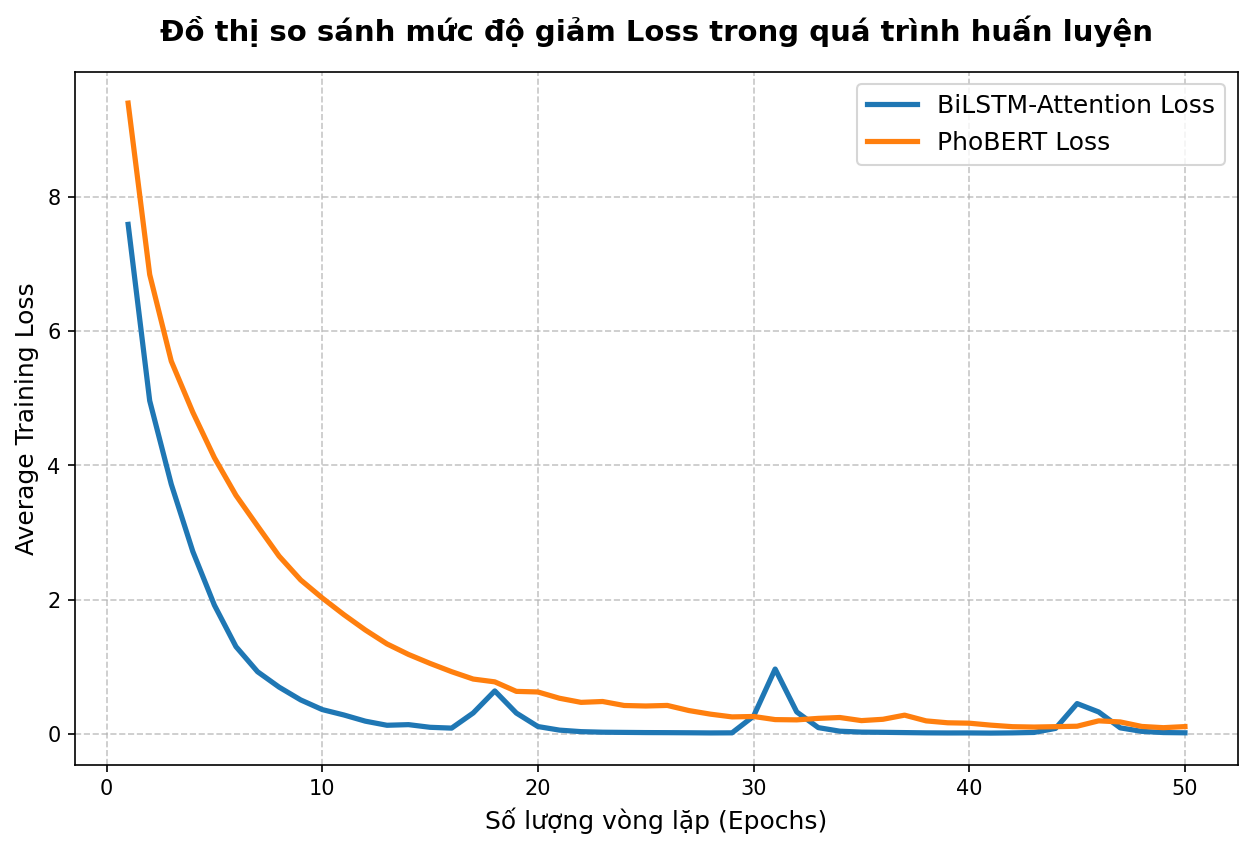

In [ ]:
import matplotlib.pyplot as plt

image_dir = 'images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

epochs_count = len(bilstm_losses)
epochs_range = range(1, epochs_count + 1)

plt.figure(figsize=(10, 6), dpi=150)

plt.plot(epochs_range, bilstm_losses, label='BiLSTM-Attention Loss',
         color='#1f77b4', linewidth=2.5, linestyle='-')

plt.plot(epochs_range, phobert_losses, label='PhoBERT Loss',
         color='#ff7f0e', linewidth=2.5, linestyle='-')

plt.title('Đồ thị so sánh mức độ giảm Loss trong quá trình huấn luyện', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Số lượng vòng lặp (Epochs)', fontsize=12)
plt.ylabel('Average Training Loss', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(fontsize=12, loc='upper right')

save_path = os.path.join(image_dir, 'training_loss_comparison.png')
plt.savefig(save_path, bbox_inches='tight', dpi=300)

plt.show()